# Exercise 1 - 3D - 2D

In [1]:
import numpy as np
import cv2 as cv2
from numpy.linalg import inv, pinv
import matplotlib.pyplot as plt

Recall from the slides the steps from Algorithm 3:

![title](algorithm_3.png)

![title](PnP.png)

# Exercise 1a)
The steps 1)-2.1) has already been done, and is saved in corresponding files. The exercise is to implement step 2.2) by filling in the missing code below

In [6]:
def featureTracking(prev_img, next_img, prev_points, world_points):
    """
    Tracks features from prev_img to next_img.
    Filters points that could not be tracked.
    """
    # Define parameters for optical flow
    params = dict(winSize=(21, 21),
                  maxLevel=3,
                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    # Calculate optical flow to track features
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, next_img, prev_points, None, **params)
    
    # Flatten the status array to make it compatible with the point arrays
    status = status.flatten()
    
    # Filter out points where tracking failed
    good_prev_points = prev_points[status == 1]
    good_next_points = next_points[status == 1]
    good_world_points = world_points[status == 1]
    
    return good_world_points, good_prev_points, good_next_points


Hint: Exercise 4 in week 2

# Exercise 1b)
Continue the algorithm by implementing step 2.3)

In [7]:
# Camera matrix (Intrinsic parameters)
K = np.array([[7.188560e+02, 0.000000e+00, 6.071928e+02], 
              [0, 7.188560e+02, 1.852157e+02],
              [0, 0, 1]])

# Load the initial frame (reference image) for tracking
reference_img = np.load("img_0.npy")  # Assuming img_0.npy is I_{k-2}

# Initialize lists for translation and rotation vectors
translations = []
rotations = []

for t in range(1, 6):
    # Load images and data for the current time step
    curImage = np.load("img_" + str(t) + ".npy")
    landmark_3D = np.load("landmark_" + str(t-1) + ".npy")
    reference_2D = np.load("reference_2D_" + str(t-1) + ".npy")
    
    # Track features from previous to current frame
    landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(reference_img, curImage, reference_2D, landmark_3D)
    
    # Estimate pose using PnP with RANSAC
    success, rvec, tvec, inliers = cv2.solvePnPRansac(landmark_3D, tracked_2Dpoints, K, None)
    
    if success:
        translations.append(tvec.ravel())
        rotations.append(rvec.ravel())
    
    # Update for the next timestep
    reference_img = curImage

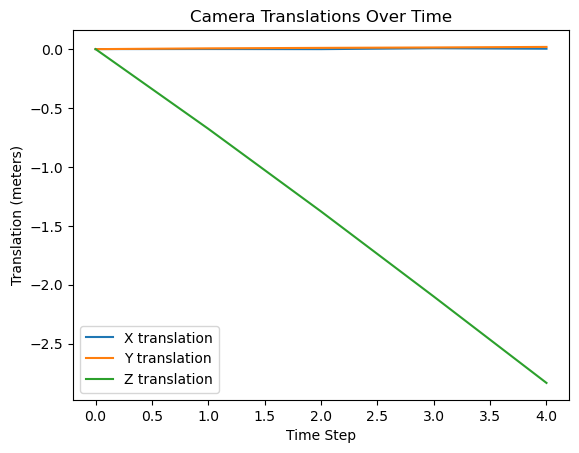

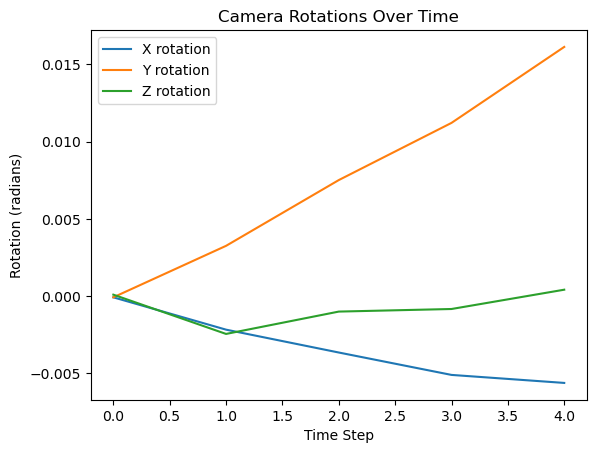

In [8]:
# Convert lists to arrays for easier plotting
translations = np.array(translations)
rotations = np.array(rotations)

# Plotting the translations over time
plt.figure()
plt.plot(translations[:, 0], label='X translation')
plt.plot(translations[:, 1], label='Y translation')
plt.plot(translations[:, 2], label='Z translation')
plt.legend()
plt.title("Camera Translations Over Time")
plt.xlabel("Time Step")
plt.ylabel("Translation (meters)")
plt.show()

# Plotting the rotations over time
plt.figure()
plt.plot(rotations[:, 0], label='X rotation')
plt.plot(rotations[:, 1], label='Y rotation')
plt.plot(rotations[:, 2], label='Z rotation')
plt.legend()
plt.title("Camera Rotations Over Time")
plt.xlabel("Time Step")
plt.ylabel("Rotation (radians)")
plt.show()